# Advanced Lane Finding

The purpose of this code is to calibrate our camera using the 20 chessboard images provided.

A chessboard is used for camera calibration since its regular patterns of high contrast make it easy to detect automatically. So, if we use our camera to take multiple pictures of chessboard agaisnt a flat surface, then we will be able to detect any distortion by looking at the difference between the appartent size and shape of the squares of the chessboard pattern.

We will start by importing all relevant libraries such as opencv, numpy required.

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import natsort
import pickle

## Finding Corners

In this exercise, you'll use the OpenCV functions **findChessboardCorners()** and **drawChessboardCorners()** to automatically find and draw corners in an image of a chessboard pattern.

To learn more about both of those functions, you can have a look at the OpenCV documentation here: [**cv2.findChessboardCorners()**](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) and [**cv2.drawChessboardCorners()**](https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.drawChessboardCorners).


## Calibrate Camera Function

Camera calibration, given object points, image points, and the shape of the grayscale image:

#### ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

Undistorting a test image:

#### dst = cv2.undistort(img, mtx, dist, None, mtx)

### Correcting for distortion

There are two main steps to this process: use chessboard images to obtain image points and object points, and then use the OpenCV functions cv2.calibrateCamera() and cv2.undistort() to compute the calibration and undistortion. 

In [2]:
def calibrate_camera(nx, ny):
    # function to calibrate the camera over different chessboard images and input the x and y corners

    # get the list of images
    images = glob.glob('camera_cal/calibration*.jpg')

    # sorting the images based on ids
    images = natsort.natsorted(images)
    # images = glob.glob('test_images/test*.jpg')

    # creating arrays to store object and image points from all the images
    objpoints = []      # 3D object points in real space
    imgpoints = []      # 2D points in image space

    # prepare object points
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)    # x, y cor-ordinates

    # iterate through the images
    for fname in images:

        # read file
        img = cv2.imread(fname)

        # grab the filenames and extensions for saving result files later
        filename_w_ext = os.path.basename(fname)
        filename, file_extension = os.path.splitext(filename_w_ext)

        # convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        # print(ret)

        # If found, we will get image coordinates
        if (ret == True):
            # add the corners and objectpoints to our lists
            imgpoints.append(corners)
            objpoints.append(objp)

            # draw and display the corners
            img_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            # cv2.imshow('img',img_corners)
            # cv2.waitKey(0)

            # save the drawn chessboard corners
            # mpimg.imsave(('output_images/chessboard_corners/'+filename+'-corners'+file_extension), img_corners)
            # cv2.imwrite(('output_images/chessboard_corners/'+'corners-'+filename+file_extension), img_corners)

            # calculate and save undistorted images
            # ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
            # undist = cv2.undistort(img, mtx, dist, None, mtx)
            # cv2.imwrite(('output_images/undistorted_chessboard_corners/'+'undistorted-'+filename+file_extension), undist)
        

    # cv2.destroyAllWindows()

    # sample one image for undistortion demo
    
    img = cv2.imread('camera_cal/calibration3.jpg')
    img_size = (img.shape[1], img.shape[0])

    # camera calibration after giving object points and image points

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('output_images/test_undist.jpg',dst)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "pickle/wide_dist_pickle.p", "wb" ) )
    
    # Visualize undistortion
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return mtx, dist

## Perspective Transform Function

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform you’ll be most interested in is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.

In [3]:
def unwarp_corners(mtx,dist):

    img = cv2.imread('camera_cal/calibration3.jpg')

    nx = 9
    ny = 6

    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)

    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # print(ret)
    
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here

        # Specify offset for dst points
        offset = 100

        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points, let us grab the detected outer four corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],\
                          [img_size[0]-offset, img_size[1]-offset],\
                          [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
        
    # vizualize the data
        
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Undistorted and Warped Image', fontsize=20)
    plt.show()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
    return M

### Call Calibrate_Camera() and Unwarp_Corners() Functions

Now, we will call **Calibrate Camera** and **Unwarp Corners** functions.

(Note: In the camera calibrate function, I have included code that iterates through all the 20 calibration images to draw detected chessboard corners and save the output images. After running once and the images have been saved, the lines **cv2.imwrite(('output_images/chessboard_corners/'+filename+'-corners'+file_extension), img_corners)** and **cv2.imwrite(('output_images/undistorted_chessboard_corners/'+filename+'-undistorted'+file_extension), undist)** can be commented out.)

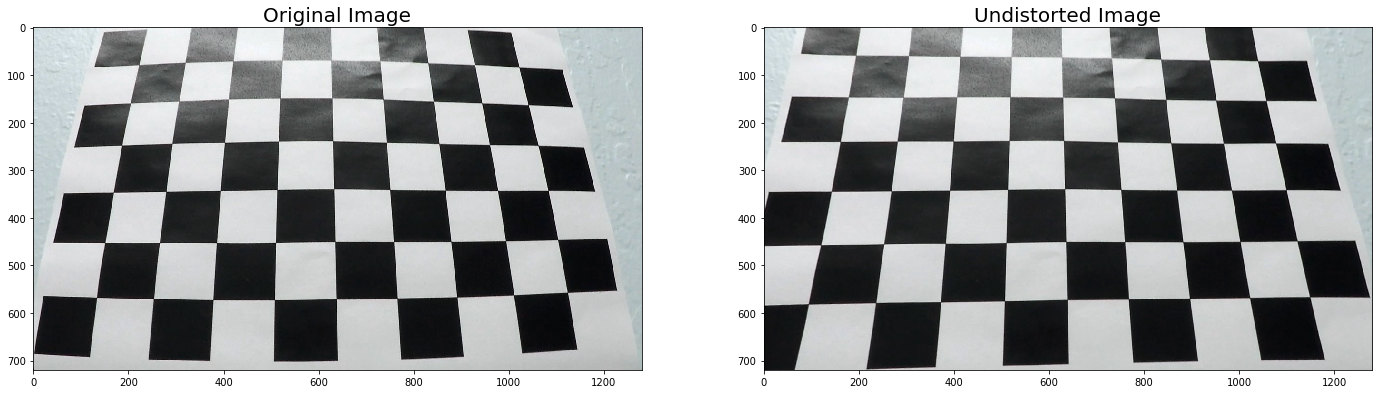

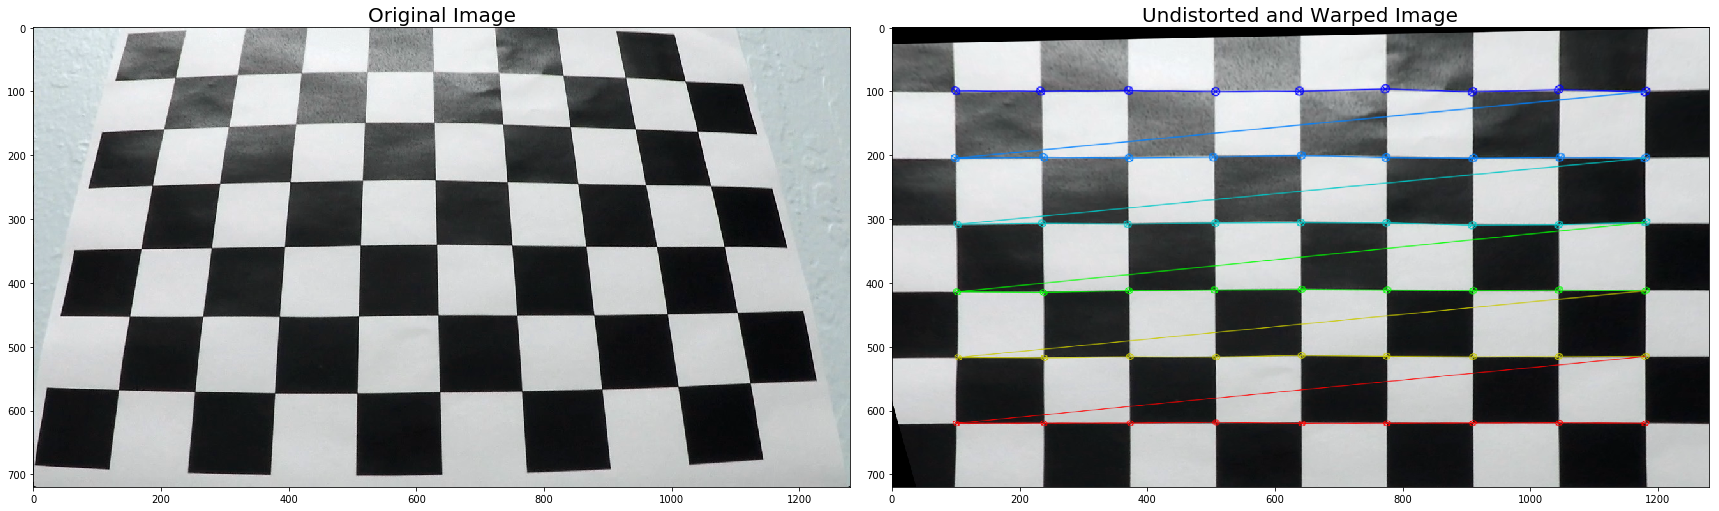

In [4]:
# function calls to calibrate camera and get the perspective matrix
mtx, dist = calibrate_camera(9,6)
perspective_M = unwarp_corners(mtx, dist)

## Thresholding Functions

In this section, I have written functions for calculating parameters such as Sobel Intensity Gradients, Gradient magnitude, gradient direction, hue, lightness, saturation and applying threshold values to idetify lanelines in images. Each of these functions will extract a binary image with the applied threshold values.

The idea behind writing different functions is that there is little extra effort involved and it is possible to use multiple combinations of these filters to achieve the best result.

In [5]:
# Thresholding functions
# since we have evaludated earlier that HLS gives good image filtering results

def hue_select(img, thresh = (0,255)):

    # 1. convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # 2. apply threshold to s channel
    h_channel = hls[:,:,0]

    # 3. create empty array to store the binary output and apply threshold
    binary_image = np.zeros_like(h_channel)
    binary_image[(h_channel > thresh[0]) & (h_channel <= thresh[1])] = 1

    return binary_image

def lightness_select(img, thresh = (120,255)):
    
    # 1. Convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    # 2. Apply threshold to s channel
    l_channel = hls[:,:,1]

    # 3. Create empty array to store the binary output and apply threshold
    binary_image = np.zeros_like(l_channel)
    binary_image[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1

    return binary_image

def saturation_select(img, thresh = (100,255)):

    # 1. convert to hls colorspace
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    # 2. apply threshold to s channel
    s_channel = hls[:,:,2]

    # 3. create empty array to store the binary output and apply threshold
    binary_image = np.zeros_like(s_channel)
    binary_image[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1

    return binary_image


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0,255)):

    # 1. Applying the Sobel depending on x or y direction and getting the absolute value
    if (orient == 'x'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    if (orient == 'y'):
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel))

    # 2. Scaling to 8-bit and converting to np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 3. Create mask of '1's where the sobel magnitude is > thresh_min and < thresh_max
    binary_image = np.zeros_like(scaled_sobel)
    binary_image[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_image


def mag_sobel(img, sobel_kernel=3, mag_thresh = (0,255)):

    # 1. Applying the Sobel (taking the derivative)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)

    # 2. Magnitude of Sobel
    mag_sobel = np.sqrt(sobelx**2 + sobely**2)

    # 3. Scaling to 8-bit and converting to np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))

    # 4. Create mask of '1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    binary_image = np.zeros_like(scaled_sobel)
    binary_image[(scaled_sobel > mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return binary_image


# Choose a Sobel kernel size

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # 1. Applying the Sobel (taking the derivative)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 2. Take absolute magnitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 3. Calculate direction using arctangent
    sobel_orient = np.arctan2(abs_sobely, abs_sobelx)
    
    # 4. Create mask of '1's where the orientation is > thresh_min and < thresh_max
    binary_image = np.zeros_like(sobel_orient)
    binary_image[(sobel_orient > thresh[0]) & (sobel_orient <= thresh[1])] = 1
    
    return binary_image

### Combined Thresholding Function

Using this function, we combine different threshold values together in a binary image.

In [6]:
# Combined Threshold Function
def combined_threshold(img):

    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    l_select = hls[:,:,1]

    # convert image to grayscale
    gray = cv2.cvtColor(hls, cv2.COLOR_BGR2GRAY)

    # applying thresholding and storing different filtered images

    h_binary = hue_select(img, thresh = (0, 255))
                          
    l_binary = lightness_select(img, thresh = (120, 255))
                          
    s_binary = saturation_select(img, thresh = (100, 255))
    
    ksize = 9
    gradex = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    # grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 255))

    mag_binary = mag_sobel(gray, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7,1.3))

    # creating an empty binary image
    combined_binary = np.zeros_like(img)
    combined_binary[((gradex == 1) | (s_binary == 1)) & ((l_binary == 1) & (h_binary == 1))] = 1

    # isolate region of interest
    height, width = gray.shape

    mask = np.zeros_like(combined_binary)
    region = np.array([[0, height-1], [width/2, int(height/2)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region], 1)

    combined_binary = cv2.bitwise_and(combined_binary, mask)

    return combined_binary

### Perspective Transform

After applying the thresholds, isolating the regions of interest and getting our binary image with identified lanelines, we apply the perspective transform to the image.
We do this using **cv2.getPerspectiveTransform(source, dst)**

In [7]:
def perspective_transform(img):
    
    height, width = img.shape
    
    # select the four points on the image

### Call the functions

In [8]:

fname = cv2.imread('test_images/straight_lines1.jpg')
result = combined_threshold(fname)
plt.imshow(result)
plt.show()

NameError: name 'binary_output' is not defined